<a href="https://colab.research.google.com/github/hsjfans/networks/blob/main/Translate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [247]:
## Model
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
import torch
%matplotlib inline

In [248]:
device = 'gpu' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [249]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [250]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [251]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [252]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [253]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [254]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

In [255]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [256]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [257]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [258]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [259]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [260]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [261]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

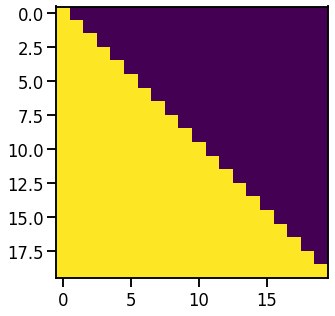

In [262]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
None

In [263]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [264]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

In [265]:
def make_model(n_src_vocab, n_tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, n_src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, n_tgt_vocab), c(position)),
        Generator(d_model, n_tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

## Handle Data

In [266]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [267]:
# !unzip -x /content/drive/MyDrive/data.zip

Archive:  /content/drive/MyDrive/data.zip
replace data/test_en? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [268]:
!ls -la

total 28
drwxr-xr-x 1 root root 4096 Dec 15 06:26 .
drwxr-xr-x 1 root root 4096 Dec 15 04:21 ..
drwxr-xr-x 1 root root 4096 Dec 10 17:17 .config
drwxr-xr-x 2 root root 4096 Dec 15 06:28 data
drwx------ 4 root root 4096 Dec 15 05:09 drive
drwxr-xr-x 3 root root 4096 Dec 15 06:26 __MACOSX
drwxr-xr-x 1 root root 4096 Dec  2 22:04 sample_data


In [269]:
import spacy
import jieba
from tqdm import tqdm
from collections import Counter
spacy_en = spacy.load('en')

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]
def tokenize_cn(text):
    return [tok for tok in jieba.cut(text)]


In [270]:
tokenize_en('asdasada,dasd,ds,asd!')

['asdasada', ',', 'dasd', ',', 'ds', ',', 'asd', '!']

In [271]:
files = {'train_src_path':'./data/train_en',
         'train_tgt_path': './data/train_cn',
         'valid_src_path': './data/valid_en',
         'valid_tgt_path': './data/valid_cn',
         'test_src_path': './data/test_en',
         'test_tgt_path': './data/test_cn'
         }

PAD_WORD = '<blank>'
UNK_WORD = '<unk>'
BOS_WORD = '<s>'
EOS_WORD = '</s>'

PAD_TOKEN = 0
UNK_TOKEN = 1
BOS_TOKEN = 2
EOS_TOKEN = 3

In [272]:
def read_files(file_type='train',max_len = 6, head = 100000):
  src_sents, tgt_sents = [], []
  with open(files[f'{file_type}_src_path']) as src_f, open(files[f'{file_type}_tgt_path']) as tgt_f:
    for idx, (src_line, tgt_line) in enumerate(tqdm(zip(src_f.readlines(),tgt_f.readlines()))):
       src_words = tokenize_en(src_line.lower().strip())
       tgt_words = tokenize_cn(tgt_line.strip())
       if len(src_words) <= max_len and len(src_words) >= 1:
          src_sents.append(src_words)
          tgt_sents.append(tgt_words)
  return src_sents, tgt_sents


In [273]:
def build_vocab(sents, extra_tokens):
   counter = Counter()
   word2idx, idx2word = {}, []
   if extra_tokens:
      idx2word += extra_tokens
      word2idx = {word: idx for idx, word in enumerate(extra_tokens)}
   for sent in tqdm(sents):
        for w in sent:
            counter.update([w])
   sorted_counter = sorted(counter.items(), key=lambda tup: tup[0])
   sorted_counter.sort(key=lambda tup: tup[1], reverse=True)
   for word, freq in sorted_counter:
      if freq <= 2: 
        continue
      idx2word.append(word)
      word2idx[word] = len(idx2word) - 1
   return counter, word2idx, idx2word

In [274]:
def convert_text2idx(examples, word2idx):
    return [[word2idx[w] if w in word2idx else UNK_TOKEN
             for w in sent] for sent in examples]


def convert_idx2text(example, idx2word):
    words = []
    for i in example:
        if i == EOS_TOKEN:
            break
        words.append(idx2word[i])
    return ' '.join(words)

In [275]:
!ls data

test_cn  test_en  train_cn  train_en  valid_cn	valid_en


In [276]:
# 构建词典
extra_tokens = [PAD_WORD, UNK_WORD, BOS_WORD, EOS_WORD]
train_src,train_tgt = read_files()







0it [00:00, ?it/s]





197it [00:00, 1960.83it/s]





419it [00:00, 2031.12it/s]





636it [00:00, 2070.21it/s]





819it [00:00, 1991.36it/s]





1017it [00:00, 1985.66it/s]





1250it [00:00, 2076.62it/s]





1502it [00:00, 2192.00it/s]





1757it [00:00, 2286.86it/s]





1999it [00:00, 2320.82it/s]





2245it [00:01, 2357.30it/s]





2492it [00:01, 2388.89it/s]





2774it [00:01, 2503.17it/s]





3087it [00:01, 2660.15it/s]





3380it [00:01, 2734.94it/s]





3656it [00:01, 2646.52it/s]





3933it [00:01, 2681.73it/s]





4228it [00:01, 2755.25it/s]





4519it [00:01, 2797.23it/s]





4801it [00:01, 2722.33it/s]





5098it [00:02, 2790.46it/s]





5407it [00:02, 2872.92it/s]





5699it [00:02, 2886.40it/s]





5989it [00:02, 2794.61it/s]





6270it [00:02, 2773.57it/s]





6549it [00:02, 1803.27it/s]





6852it [00:02, 2051.85it/s]





7143it [00:02, 2250.15it/s]





7458it [00:03, 2460.92it/s]





7775it [00:03, 2636.53it/s]





8078it [00:03, 27

KeyboardInterrupt: ignored

In [ ]:
src_counter, src_word2idx, src_idx2word = build_vocab(train_src, extra_tokens)
tgt_counter, tgt_word2idx, tgt_idx2word = build_vocab(train_tgt, extra_tokens)

In [ ]:
valid_src,valid_tgt = read_files('valid')

In [ ]:
train_src, train_tgt = convert_text2idx(train_src, src_word2idx), convert_text2idx(
            train_tgt, tgt_word2idx)
valid_src, valid_tgt = convert_text2idx(valid_src, src_word2idx), convert_text2idx(
            valid_tgt, tgt_word2idx)

In [ ]:
torch.save(
        {
            'src_dict': (src_counter, src_word2idx, src_idx2word),
            'tgt_dict': (tgt_counter, tgt_word2idx, tgt_idx2word),
        }, '{}_dict'.format('/content/drive/MyDrive/train')
    )

torch.save(
        {
            'train_src': train_src,     'train_tgt': train_tgt,
            'dev_src': valid_src,       'dev_tgt': valid_tgt,
            'src_dict': src_word2idx,  'tgt_dict': tgt_word2idx,
        }, '{}_train'.format('/content/drive/MyDrive/train')
    )

In [ ]:
from torchtext.data import Field, Iterator
import torchtext.data as data

class ParallelDataset(data.Dataset):
    """Defines a custom dataset for machine translation."""
    @staticmethod
    def sort_key(ex):
        return data.interleave_keys(len(ex.src), len(ex.trg))

    def __init__(self, src_examples, trg_examples, fields, **kwargs):
        """Create a Translation Dataset given paths and fields.

        Arguments:
            path: Path to the data preprocessed with preprocess.py
            category: Whether the Dataset is for training or development
            fields: A tuple containing the fields that will be used for data
                in each language.
            Remaining keyword arguments: Passed to the constructor of
                data.Dataset.
        """
        if not isinstance(fields[0], (tuple, list)):
            if trg_examples is None:
                fields = [('src', fields[0])]
            else:
                fields = [('src', fields[0]), ('tgt', fields[1])]

        examples = []
        if trg_examples is None:
            for src_line in src_examples:
                examples.append(data.Example.fromlist(
                    [src_line], fields))
        else:
            for src_line, trg_line in zip(src_examples, trg_examples):
                examples.append(data.Example.fromlist(
                    [src_line, trg_line], fields))

        super(ParallelDataset, self).__init__(examples, fields, **kwargs)


In [ ]:
src_field = Field(sequential=True, use_vocab=False, include_lengths=True, batch_first=True,
                      pad_token=PAD_TOKEN, unk_token=UNK_TOKEN, init_token=None, eos_token=None,)
tgt_field = Field(sequential=True, use_vocab=False, include_lengths=True, batch_first=True,
                      pad_token=PAD_TOKEN, unk_token=UNK_TOKEN, init_token=BOS_TOKEN, eos_token=EOS_TOKEN,)
fields = (src_field, tgt_field)

def filter_pred(example,max_src_len = 6):
    if len(example.src) <= max_src_len :
        return True
    return False

In [ ]:
def load_train_data(batch_size = 64):

  train_data = ParallelDataset(
        train_src, train_tgt, fields=fields, filter_pred=filter_pred,)
  train_iter = Iterator(dataset=train_data, batch_size=batch_size, train=True,
                          sort_key=lambda x: data.interleave_keys(
                              len(x.src), len(x.tgt)),
                          repeat=False, shuffle=True, device=device)
  valid_data = ParallelDataset(valid_src, valid_tgt, fields=fields,)
  valid_iter = Iterator(dataset=valid_data, batch_size=batch_size, train=False,
                        repeat=False, device=device, shuffle=False, sort=False,)
  
  return  train_iter, valid_iter



## Train

In [ ]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item() * norm

In [ ]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

In [ ]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    desc = '- (Training)' if loss_compute is not None else '- (Valid)'
    for data in tqdm(data_iter,mininterval= 3, desc=desc, leave=False):
        batch = Batch(data.src[0],data.tgt[0])
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        # if i % 50 == 1:
        #     elapsed = time.time() - start
        #     print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
        #             (i, loss / batch.ntokens, tokens / elapsed))
        #     start = time.time()
        #     tokens = 0
    return total_loss / total_tokens

In [ ]:
def save_checkpoint(model, epoch):
  checkpoint = {'model':model, 'epoch':epoch}
  torch.save(checkpoint,f'/content/drive/MyDrive/translate_{epoch}.chkpt')

In [ ]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

In [ ]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [ ]:
n_src_vocab = len(src_word2idx)
n_tgt_vocab = len(tgt_word2idx)
epochs = 10
criterion = LabelSmoothing(size=n_tgt_vocab, padding_idx=0, smoothing=0.0)
model = make_model(n_src_vocab,n_tgt_vocab)
model_opt = get_std_opt(model)


In [ ]:
train_iter,valid_iter = load_train_data()

In [ ]:
save_checkpoint(model, 0)

In [ ]:
for epoch in range(epochs):
  model.train()
  train_loss = run_epoch(train_iter, model, SimpleLossCompute(model.generator, criterion, model_opt))
  model.eval()
  valid_loss = run_epoch(valid_iter, model, SimpleLossCompute(model.generator, criterion, None))
  print(f'valid_loss: {valid_loss}, train_loss: {train_loss}')

  if epoch % 2 == 0:
    save_checkpoint(model, epoch)
